# 使用 DeepSeek 制定量化策略

In [1]:
# -*- coding: utf-8 -*-
# 中信证券量化分析实战脚本
# 环境需求：Python 3.6+，安装库：akshare, pandas, matplotlib, numpy

import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [2]:

# ================= 数据获取 =================
def get_stock_data():
    """获取中信证券后复权数据"""
    try:
        # 中信证券代码：600030
        df = ak.stock_zh_a_hist(symbol="600030", period="daily", adjust="qfq")
        df['日期'] = pd.to_datetime(df['日期'])
        df.set_index('日期', inplace=True)
        df = df[['开盘', '最高', '最低', '收盘', '成交量']]
        df.rename(columns={
            "开盘": "open",
            "最高": "high",
            "最低": "low", 
            "收盘": "close",
            "成交量": "volume"
        }, inplace=True)
        return df.sort_index(ascending=True)
    except Exception as e:
        print(f"数据获取失败，请检查akshare接口是否更新。错误信息：{e}")
        return None

# ================= 技术指标计算 =================
def calculate_indicators(df):
    """计算技术指标"""
    # 1. 均线
    df['MA5'] = df['close'].rolling(5).mean()
    df['MA20'] = df['close'].rolling(20).mean()
    
    # 2. MACD
    exp12 = df['close'].ewm(span=12, adjust=False).mean()
    exp26 = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Histogram'] = df['MACD'] - df['Signal']
    
    # 3. RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df.dropna()

# ================= 可视化与信号分析 =================
def analyze_trend(df):
    """可视化分析"""
    plt.figure(figsize=(14, 12))
    
    # 子图1: 价格与均线
    plt.subplot(3,1,1)
    plt.plot(df.index, df['close'], label='Close', linewidth=1, alpha=0.8)
    plt.plot(df.index, df['MA5'], label='MA5', linestyle='--', color='orange')
    plt.plot(df.index, df['MA20'], label='MA20', linestyle='--', color='purple')
    plt.title('CITIC SEC (600030) - Price Trend')
    plt.legend()
    
    # 子图2: MACD
    plt.subplot(3,1,2)
    plt.bar(df.index, df['Histogram'], label='MACD Histogram', color=np.where(df['Histogram']>0, 'red', 'green'))
    plt.plot(df.index, df['MACD'], label='MACD', color='blue')
    plt.plot(df.index, df['Signal'], label='Signal', color='orange')
    plt.title('MACD Analysis')
    plt.legend()
    
    # 子图3: RSI
    plt.subplot(3,1,3)
    plt.plot(df.index, df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', alpha=0.5)
    plt.axhline(30, linestyle='--', color='green', alpha=0.5)
    plt.title('RSI (14-day)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# ================= 信号解读 =================
def generate_signal_report(df):
    """生成信号报告"""
    last_row = df.iloc[-1]
    
    # 1. 均线信号
    ma_signal = "多头排列（看涨）" if last_row['MA5'] > last_row['MA20'] else "空头排列（看跌）"
    
    # 2. MACD信号
    macd_status = "金叉买入信号" if last_row['MACD'] > last_row['Signal'] else "死叉卖出信号"
    
    # 3. RSI信号
    if last_row['RSI'] > 70:
        rsi_status = "超买区域（警惕回调）"
    elif last_row['RSI'] < 30:
        rsi_status = "超卖区域（或有反弹）"
    else:
        rsi_status = "中性区域"
    
    # 生成报告
    report = f"""
    === 中信证券技术面分析报告（截止 {df.index[-1].strftime('%Y-%m-%d')}） ===
    1. 【均线系统】MA5 (¥{last_row['MA5']:.2f}) 与 MA20 (¥{last_row['MA20']:.2f})
       ➜ 当前信号：{ma_signal}
    
    2. 【MACD指标】MACD ({last_row['MACD']:.2f}) / Signal ({last_row['Signal']:.2f})
       ➜ 状态：{macd_status}
    
    3. 【RSI指标】当前值 {last_row['RSI']:.1f}
       ➜ 解读：{rsi_status}
    
    关键价位：
    - 支撑位：MA20 (¥{last_row['MA20']:.2f})
    - 压力位：近30日最高价 ¥{df['high'][-30:].max():.2f}
    """
    print(report)


In [3]:
def calculate_volume_indicators(df):
    """量价分析指标计算"""
    # 1. 成交量加权平均价（VWAP）
    df['Cum_Volume'] = df['volume'].cumsum()
    df['Cum_Price_Volume'] = (df['close'] * df['volume']).cumsum()
    df['VWAP'] = df['Cum_Price_Volume'] / df['Cum_Volume']
    
    # 2. 能量潮（OBV）
    df['OBV'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
    
    # 3. 量价趋势指标（VPT）
    df['VPT'] = (df['volume'] * (df['close'] - df['close'].shift(1)) / df['close'].shift(1)).cumsum()
    
    # 4. 量价背离检测
    df['Price_High'] = df['close'].rolling(10).max()  # 最近10日最高价
    df['Volume_High'] = df['volume'].rolling(10).max() # 最近10日最大成交量
    return df

def analyze_volume_price(df):
    """量价分析可视化"""
    plt.figure(figsize=(14, 8))
    
    # 价格与成交量分析
    ax1 = plt.subplot(2,1,1)
    ax1.plot(df.index, df['close'], label='Close', color='blue')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', colors='blue')
    
    ax2 = ax1.twinx()
    ax2.bar(df.index, df['volume'], label='Volume', color='gray', alpha=0.3)
    ax2.set_ylabel('Volume', color='gray')
    ax2.tick_params(axis='y', colors='gray')
    plt.title('Price-Volume Analysis')
    
    # VWAP与OBV分析
    plt.subplot(2,1,2)
    plt.plot(df.index, df['VWAP'], label='VWAP', color='red', linestyle='--')
    plt.plot(df.index, df['OBV']/1000000, label='OBV (million)', color='green')
    plt.title('VWAP & OBV Trend')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def generate_volume_signal(df):
    """生成量价信号"""
    latest = df.iloc[-1]
    
    # 量价背离检测
    price_trend = "上涨" if latest['close'] > df['close'].iloc[-5] else "下跌"
    volume_trend = "放大" if latest['volume'] > df['volume'].iloc[-5] else "萎缩"
    
    divergence = ""
    if (price_trend == "上涨") and (volume_trend == "萎缩"):
        divergence = "顶背离（价格上涨但成交量萎缩 ➜ 趋势可能反转）"
    elif (price_trend == "下跌") and (volume_trend == "放大"):
        divergence = "底背离（价格下跌但成交量放大 ➜ 可能触底反弹）"
    
    # 关键信号
    signals = [
        f"- 当前量价趋势：价格{price_trend}，成交量{volume_trend}",
        f"- VWAP（成交量加权均价）：¥{latest['VWAP']:.2f}，当前价格{'高于' if latest['close']>latest['VWAP'] else '低于'}VWAP",
        f"- OBV能量潮趋势：{'上升（资金流入）' if latest['OBV'] > df['OBV'].iloc[-5] else '下降（资金流出）'}",
        f"- 量价背离检测：{divergence if divergence else '无量价背离'}"
    ]
    return signals



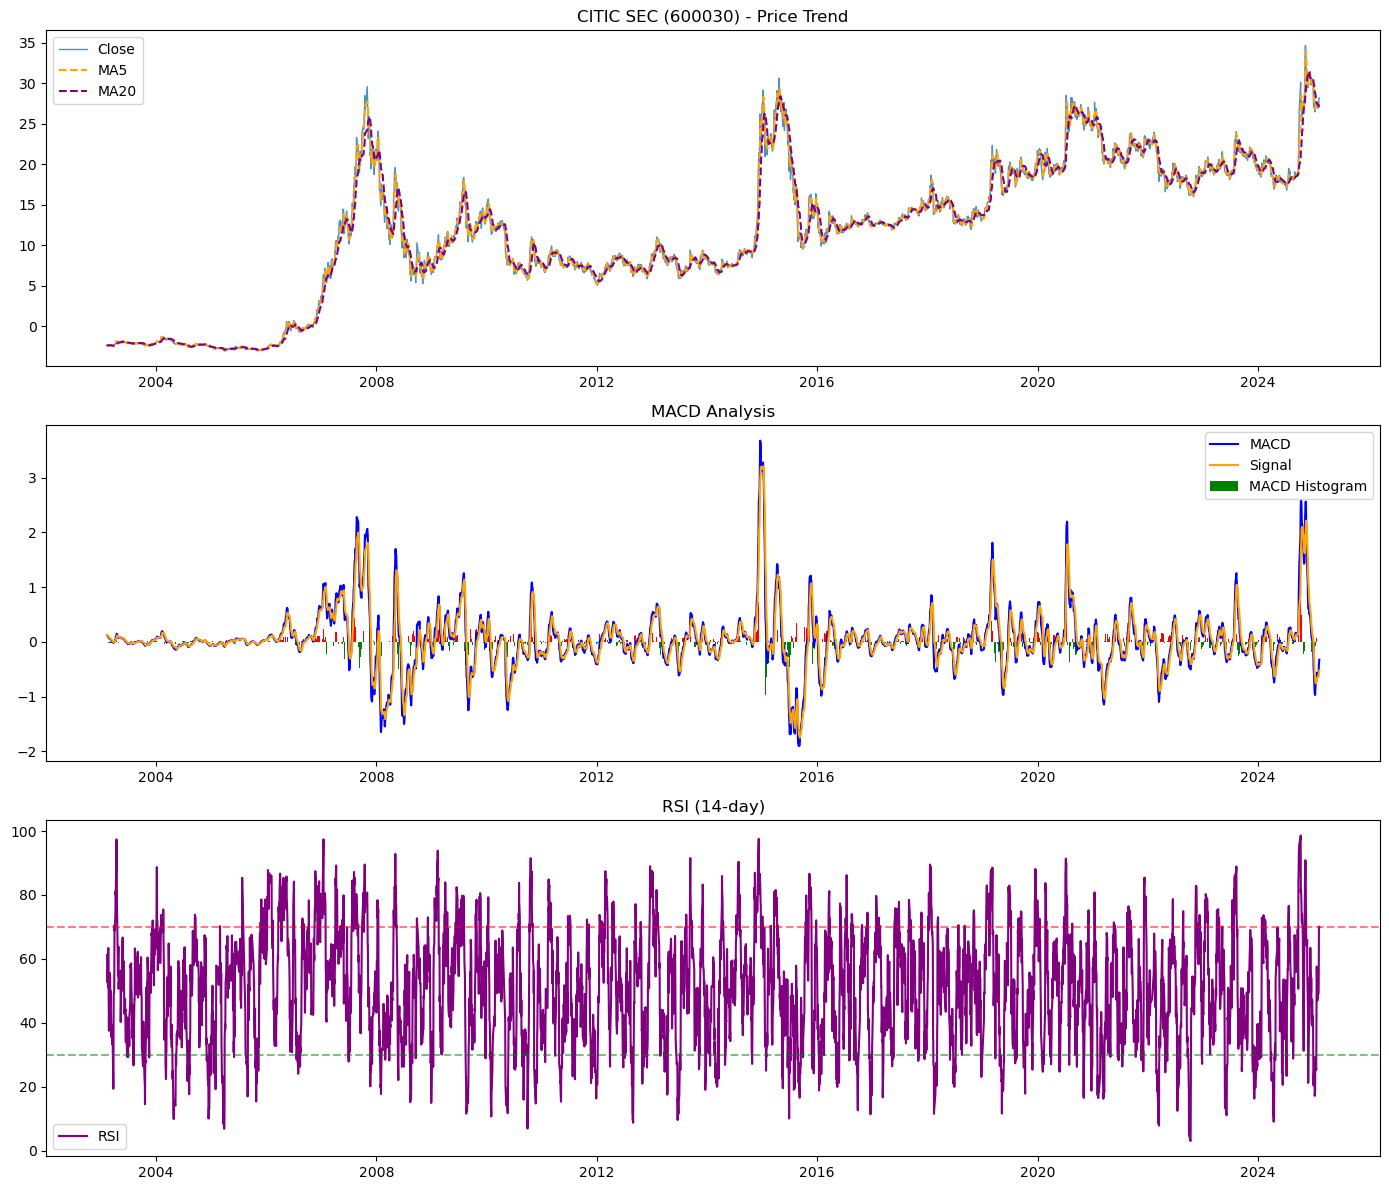

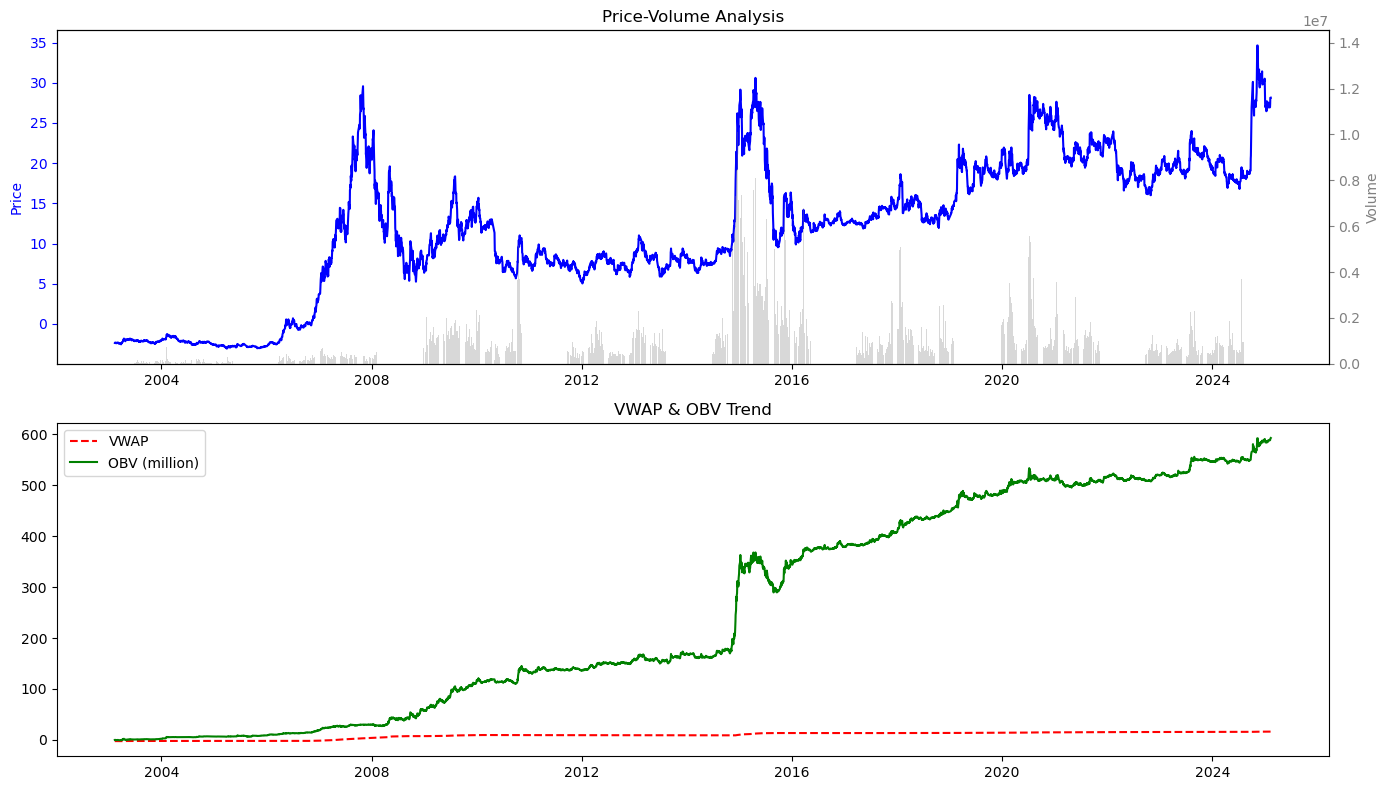


    === 中信证券技术面分析报告（截止 2025-02-10） ===
    1. 【均线系统】MA5 (¥27.51) 与 MA20 (¥27.26)
       ➜ 当前信号：多头排列（看涨）
    
    2. 【MACD指标】MACD (-0.33) / Signal (-0.52)
       ➜ 状态：金叉买入信号
    
    3. 【RSI指标】当前值 69.8
       ➜ 解读：中性区域
    
    关键价位：
    - 支撑位：MA20 (¥27.26)
    - 压力位：近30日最高价 ¥30.76
    

=== 量价分析补充报告 ===
- 当前量价趋势：价格上涨，成交量放大
- VWAP（成交量加权均价）：¥16.27，当前价格高于VWAP
- OBV能量潮趋势：上升（资金流入）
- 量价背离检测：无量价背离


In [4]:
df = get_stock_data()
if df is not None:
    df = calculate_indicators(df)
    df = calculate_volume_indicators(df)  # 新增量价指标
    
    # 可视化分析
    analyze_trend(df)        # 原技术分析图表
    analyze_volume_price(df) # 新增量价分析图表
    
    # 信号报告
    generate_signal_report(df)
    volume_signals = generate_volume_signal(df)
    print("\n=== 量价分析补充报告 ===")
    print("\n".join(volume_signals))